<a href="https://colab.research.google.com/github/R1M1N/ZTM_tf2/blob/main/05_Fine_Tuning_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What are we going to cover
- Introduce fine-tuning transfer learning with TF
- Keras Functional API to build models
- Use small dataset to experiment faster
- Data Augmentation (without adding images, make training set more diverse)
- Running experiments on Food Vision Data
- Introduce model check point call back to save intermediate training results


So we have been writing the walkthrough unzip and couple of other functions again and again in different notebook why not create a [helper_functions.py](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) and make it accessible always.


In [49]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-12 09:54:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-11-12 09:54:28 (16.2 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [50]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [51]:
# You need to re-download the the helper-functions in every runtime because colab deletes it.

### Let's get some data
We learn how to use tf.keras.application which has bunch of pretrained models https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [52]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-11-12 09:54:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   284MB/s    in 0.6s    

2023-11-12 09:54:29 (284 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [53]:
# Check how many files are there in the folder
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [54]:
# Let's load our data
# Create our training and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [55]:
# Create some batches
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [56]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [57]:
# Check class names of our training data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [58]:
train_data_10_percent.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [59]:
for images,labels in train_data_10_percent.take(2):
  print(images,labels)

tf.Tensor(
[[[[3.00000000e+00 5.00000000e+00 2.00000000e+00]
   [2.00000000e+00 4.00000000e+00 1.00000000e+00]
   [1.21428585e+00 3.21428585e+00 2.14285851e-01]
   ...
   [7.85705566e-01 5.70917177e+00 1.70917189e+00]
   [0.00000000e+00 4.04590702e+00 4.59071621e-02]
   [4.13262546e-01 5.28570986e+00 1.28570998e+00]]

  [[2.04591823e+00 4.04591799e+00 1.04591823e+00]
   [2.00000000e+00 4.00000000e+00 1.00000000e+00]
   [1.21428585e+00 3.21428585e+00 2.14285851e-01]
   ...
   [9.84693289e-01 5.98469353e+00 1.98469329e+00]
   [9.28571701e-01 5.92857170e+00 1.92857170e+00]
   [3.16835928e+00 8.16835976e+00 4.16835928e+00]]

  [[1.78571415e+00 3.78571415e+00 1.21428585e+00]
   [1.78571415e+00 3.78571415e+00 7.85714149e-01]
   [1.95408154e+00 3.95408154e+00 9.54081595e-01]
   ...
   [2.59693718e+00 6.95407963e+00 3.07652497e+00]
   [2.62755513e+00 6.98469782e+00 2.77041173e+00]
   [5.07142448e+00 9.42856693e+00 5.21428108e+00]]

  ...

  [[4.45153465e+01 3.60868187e+01 2.53010845e+01]
   [4

## Basic overview of the process
#### Preprocessing the data
- Get the [helper_functions.py](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py)
file always and import some functions in it.
- You may create different helper functions and use them directly here.
- Then get the data by downloading it from the net and then unzip it using unzip_data function imported from helper_functions.py.
- then walk_through_dir to know what folders do you have and how many images are there in each folder
- Then split the directories in Train and Test dir
- then set an IMG_SIZE, BATCH_SIZE and EPOCHS
- Then turn that those training and testing directories into data batches via image_dataset_from_directory(directory=path_to_directory,image_size=IMG_SIZE,batch_size=BATCH_SIZE,label_mode=BINARY OR CATEGORICAL)
- you can check the shape by typing the name of the data.
- You can also check the class names by adding .class_names

#### Creating a model
 1. BASE MODEL with tf.keras.applications.MODEL_NAME(include_top=(binary)) base_model as model
 2. if True then you cannot change the output shape if false then you can
 3. set base_model.trainable = False if you do not want the whole model to train
 4. Define the input layer with shape and name
 5. if ResNetv2 it will need normalization if or rescaling
 6. Pass the inputs to the base model x as layer
 7. Add a pooling layer to pick the most important features and reduce the number of computations x as layer GlobalAveragePooling2D
 8. write an output layer and pass the x as layer with Dense layer and neurons=classes, activation=(softmax or sigmoid) and name
 9. Combine the input and upto x(outut) layers via keras.Model()
 10. Compile the model loss (binary_crossentropy,sparse_categorical or categorical), optimizers (SGD or Adam), metrics (accuracy, recall precision f1)
 11. Fit the model (history = model.fit(train_data,epochs,steps_per_epoch,validation_data,validation_steps), callbacks)

In [60]:
# Let's build a efficientnetB0 model with tf.keras.applications
# 1. BASE MODEL with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so prelearned patterns remain same)
base_model.trainable = False

# 3. Create the inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='Input_Layer')

# 4. If using ResNetv2 you will have to normalize the model
# x = tf.keras.layers.experimental.preprocessing.Normalization()(inputs)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model (EfficientNet doesnt use normalized data it gets normalized automatically with this model)
x = base_model(inputs)
# Check shape after pass input to base model
print(f"Shape after base model gets inputs {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important features and use reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After Pooling {x.shape}")

# 7 Create an output activation
output = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the input and the output layers using tf.keras.Model()
model_0 = tf.keras.Model(inputs,output)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")
# 10. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("Tensorflow_hub","Efficient_net_Feature_extraction")])








Shape after base model gets inputs (None, 7, 7, 1280)
After Pooling (None, 1280)
Saving TensorBoard log files to: Tensorflow_hub/Efficient_net_Feature_extraction/20231112-095438
Epoch 1/5
24/24 [==============================] - 17s 440ms/step - loss: 1.8317 - accuracy: 0.4427 - val_loss: 1.2705 - val_accuracy: 0.7492
Epoch 2/5
24/24 [==============================] - 8s 301ms/step - loss: 1.0744 - accuracy: 0.7800 - val_loss: 0.8493 - val_accuracy: 0.8360
Epoch 3/5
24/24 [==============================] - 9s 363ms/step - loss: 0.7749 - accuracy: 0.8267 - val_loss: 0.6820 - val_accuracy: 0.8580
Epoch 4/5
24/24 [==============================] - 9s 361ms/step - loss: 0.6267 - accuracy: 0.8667 - val_loss: 0.5987 - val_accuracy: 0.8640
Epoch 5/5
24/24 [==============================] - 8s 311ms/step - loss: 0.5328 - accuracy: 0.8907 - val_loss: 0.5438 - val_accuracy: 0.8720


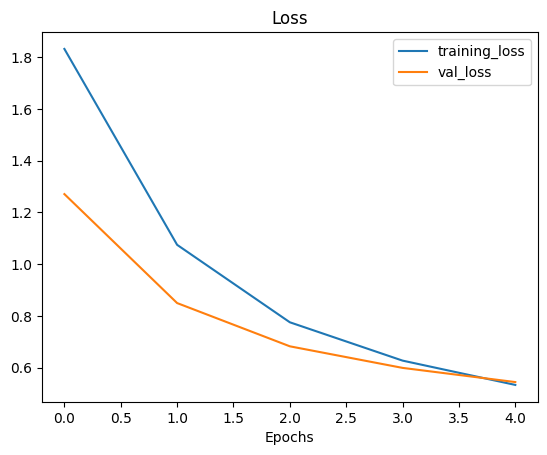

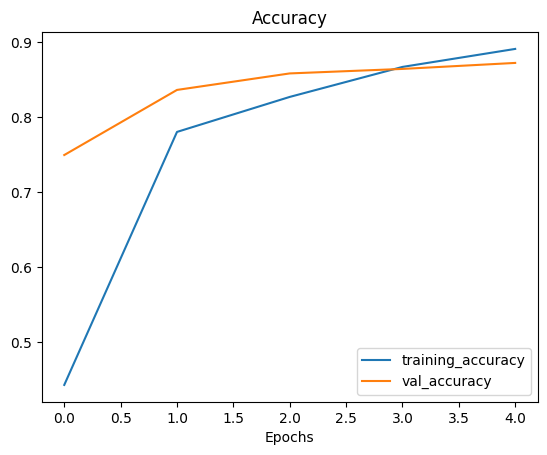

In [61]:
plot_loss_curves(history_model_0)

In [62]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_4
1 rescaling_4
2 normalization_3
3 rescaling_5
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [63]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_3

In [64]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

## Getting a feature vector from a trained model

We kinda dont know what going on in our feature vector i.e. GlobalAveragePooling2D() from (None,7,7,1280) what does it do that it gets (None,1280) its like it gets rid of them.
Let's see an example using (1,4,4,3)

In [65]:
# Define input shape(1,4,4,3)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
tensor_1 = tf.random.normal(input_shape)
print(f"Random Input Tensor: {tensor_1}\n")

# Passing it to global average pooling layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(tensor_1)
print(f"Global Average Pooled Tesor: {global_average_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {tensor_1.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooling_tensor.shape}")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Global Average Pooled Tesor: [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [66]:
# Let's replicate the global average pooling tensor
tf.reduce_mean(tensor_1,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [67]:
# Let's try with GlobalMaxPooling
# Define input shape(1,4,4,3)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
tensor_1 = tf.random.normal(input_shape)
print(f"Random Input Tensor: {tensor_1}\n")

# Passing it to global average pooling layer
global_max_pooling_tensor = tf.keras.layers.GlobalMaxPooling2D()(tensor_1)
print(f"Global Max Pooled Tesor: {global_max_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {tensor_1.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_max_pooling_tensor.shape}")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Global Max Pooled Tesor: [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [68]:
tf.reduce_max(tensor_1,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments
1. `model_1`: use feature extraction with 1% of the training data with data augmentation.

2. `model_2` : use feature extraction with 10% of the data with data augmentation.

3. `model_3` : use fine-tuning to with 10% of the training data with data augmentation.

4. `model_4` : use fine-tuning with 100% of the training data with data augmentation.


### The data augmentation done is:
- Random Flip
- Rotation
- Zoom
- Height
- Width

## Creating model_1 with 1% of the training data

In [69]:
# Let's start fresh and download the 1% data from https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-11-12 09:55:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   159MB/s    in 0.8s    

2023-11-12 09:55:45 (159 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [70]:
# Creating train and test dir
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [71]:
# Walkthrough 1 percent of the data directory and list all the files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

How to do feature extraction Transfer learning
- Unzip Data
- walkthrough
- train test folder split
- data loaders add
- base_model
- inputs
- x =base_model(inputs)
- x(pooling layer)
- output = Dense()(x)
- Create model tf.keras.Model(inputs,output)
- compile model
- fit the data to the model

In [72]:
train_dir_1_percent = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test"

In [73]:
# Data laoders to create batches
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [74]:
# Add augmentation layer to directly into our model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    # keras.preprocessing.Rescaling(1/255.) # Only for ResNetv2
    layers.RandomHeight(0.2)

],name="data_augmentation")

(-0.5, 541.5, 312.5, -0.5)

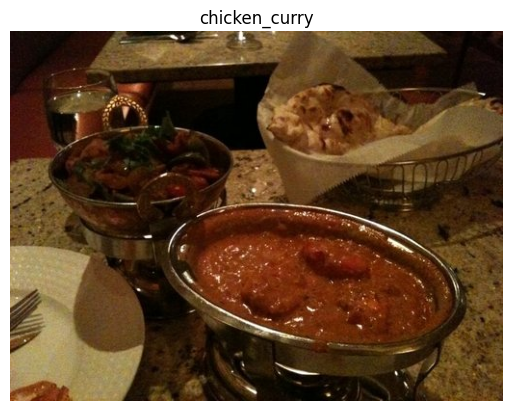

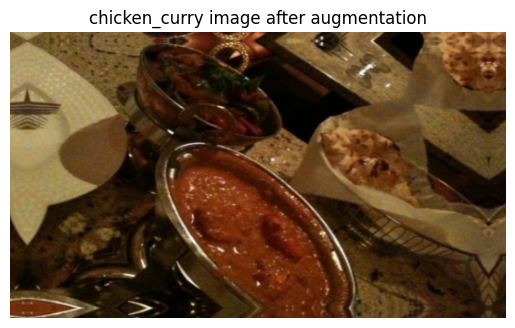

In [75]:
# Let's see what our data aumentation layer does
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from random import choice

# Let's first choose a random class
random_class =  choice(train_data_1_percent.class_names)
# Let's now select the whole path to our image
random_image = choice(os.listdir("10_food_classes_1_percent/train" + "/" + random_class))

random_image_path = train_dir_1_percent +random_class+"/" +random_image

img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(random_class)
plt.axis(False)

# Now let's plot our augmented image

plt.figure()
augmented_img = data_augmentation(img,training=True)
plt.imshow(augmented_img/255.)
plt.title(f"{random_class} image after augmentation")
plt.axis(False)

In [76]:
# Let's build the model
# First define input shape
input_shape = (224,224,3)

# Now let's choose a base model to build upon and freeze all the layers and include_top is False to set our own output layer
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Now let's create the input layer
inputs = layers.Input(input_shape,name="Input_layer")

# We do data augmentation on the inputs only so let's do it before passing to the base model
x = data_augmentation(inputs)

# Now let's put the input in our base model
x = base_model(x, training=False)

# Now let's add the pooling layer layer
x = layers.GlobalAveragePooling2D(name="Global_average_pooling_layer")(x)

# Now the output layer
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine the input and output to make a model
model_1 = keras.Model(inputs,outputs)

# Compile the model_1
model_1.compile(loss="categorical_crossentropy",
                metrics="accuracy",
                optimizer="adam")

# Fit the data to the model

history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.25)



Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4622 - accuracy: 0.0429 - val_loss: 2.3433 - val_accuracy: 0.1203
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.2792 - accuracy: 0.1000 - val_loss: 2.2281 - val_accuracy: 0.1750
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0893 - accuracy: 0.2714 - val_loss: 2.1211 - val_accuracy: 0.2234
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.9555 - accuracy: 0.3000 - val_loss: 2.0329 - val_accuracy: 0.2547
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7323 - accuracy: 0.5571 - val_loss: 1.9459 - val_accuracy: 0.3266


In [77]:
model_1.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 1.9483 - accuracy: 0.3200


[1.9482505321502686, 0.3199999928474426]

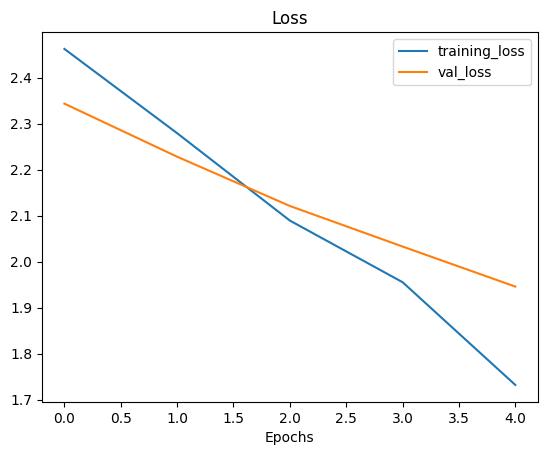

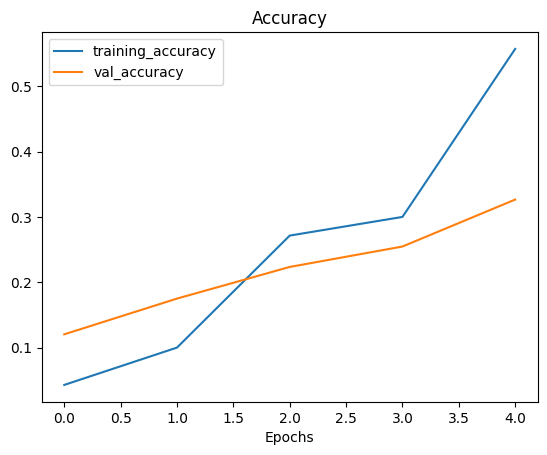

In [78]:
plot_loss_curves(history_model_1)

In [79]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

## Now Let's create model_2 with 10% of the training data and data augmentation


### We can use the shortcut actually or Completely write the whole process if you are learning you should choose the latter.


In [80]:
# Downlaod the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-11-12 09:56:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   208MB/s    in 0.8s    

2023-11-12 09:56:35 (208 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [81]:
# Define the train and test directories
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [82]:
# Define data loader and create batches
train_data_10_percent = keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=(224,224),
                                                                         label_mode="categorical",
                                                                         )
test_data = keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                             image_size=(224,224),
                                                             label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [83]:
# Now let's create the layer for data augmentation
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)

])

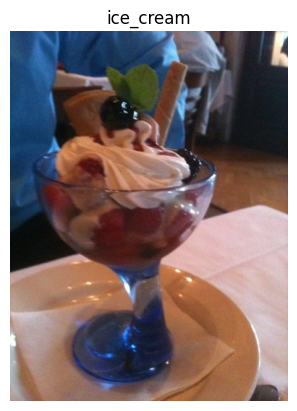

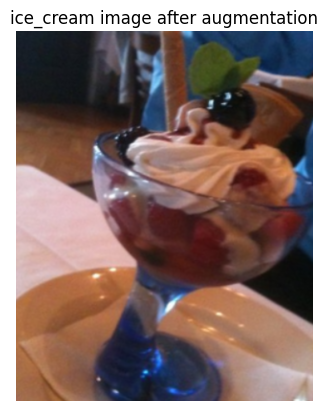

In [84]:
# Now if you want you can view how it affects an image

target_class = choice(os.listdir("/content/10_food_classes_10_percent/train/"))
target_dir = train_dir + target_class + "/"

target_image = choice(os.listdir(target_dir))
target_image_path = target_dir + target_image

# Read the image
img = mpimg.imread(target_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)

plt.figure()
plt.title(f"{target_class} image after augmentation")
plt.axis(False)
aug_img = augmentation_layer(img,training=True)
plt.imshow(aug_img/255.)

In [85]:
# So yeah it works wonderfully now let's put it in the model
# Let's create the model

In [86]:
# First we make the input layer for that define input_shape
input_shape = (224,224,3)

# Now we create the base model
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Let's now create the input layer
inputs = layers.Input(input_shape,name="Input_layer")

# Now let's pass it to our augmentation layer before feeding it to the base_model
x = augmentation_layer(inputs)

# Now let's pass this to our base model
x = base_model(x,training=False) # Pass the augmented images in inference mode in this the base model in not trained and batchnorm layers are not updated

# Let's Pool this
x = layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)

# Let's pass this through the output_layer
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# combine both the inputs and outputs
model_2 = keras.Model(inputs,outputs)

# let's compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics="accuracy")

# Let's fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=0.25*len(test_data))


Epoch 1/5
24/24 [==============================] - 24s 630ms/step - loss: 2.0274 - accuracy: 0.3320 - val_loss: 1.5036 - val_accuracy: 0.6547
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 1.4227 - accuracy: 0.6787 - val_loss: 1.0924 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - 13s 549ms/step - loss: 1.0998 - accuracy: 0.7200 - val_loss: 0.8548 - val_accuracy: 0.7969
Epoch 4/5
24/24 [==============================] - 14s 546ms/step - loss: 0.9373 - accuracy: 0.7707 - val_loss: 0.7509 - val_accuracy: 0.8172
Epoch 5/5
24/24 [==============================] - 11s 443ms/step - loss: 0.8282 - accuracy: 0.8013 - val_loss: 0.6795 - val_accuracy: 0.8250


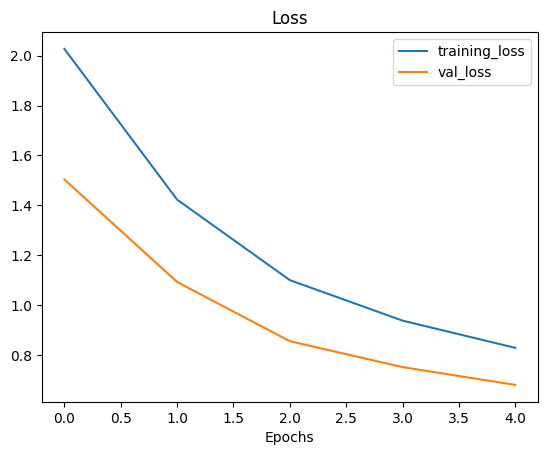

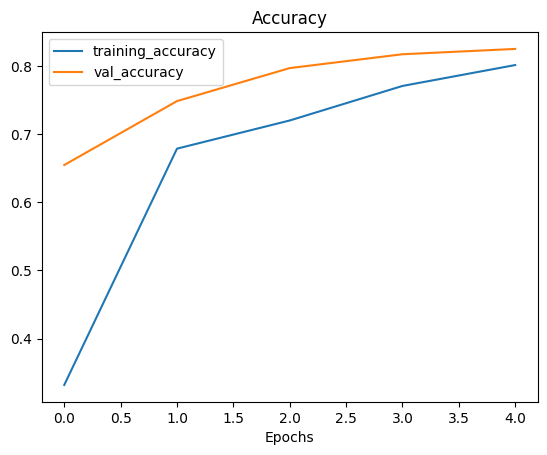

In [87]:
plot_loss_curves(history_model_2)

In [88]:
# Now let's create model 3 with fine tuning and 10% of the data